In [172]:
import numpy as np
import pandas as pd

from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.utils.plotting import plot_series

import mplfinance as mpf
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
tqdm.pandas()

import train_model as tm
from data_preprocessing import normalize_StandardScaler, normalize_MinMaxScaler, normalize_RobustScaler,normalize_MaxAbsScaler
import data_processing as dp
from data_loader import load_data_at_start_date, load_data_period
# from features import FeatureEngineering

In [2]:
df = dp.get_data('crypto_data', 'BTC-USD', compress=False) 
# display(df)

### Data analysis 

In [3]:
# handle missing value
for column, _ in df.items():
    if column == 'Volume' and df[column].isna().sum() > 0:
        df[column].fillna(value=0, inplace=True)
    elif not column == 'Volume' and df[column].isna().sum() > 0:
        df[column].fillna(method='ffill', inplace=True)

# display(df)
print(len(df))

2206


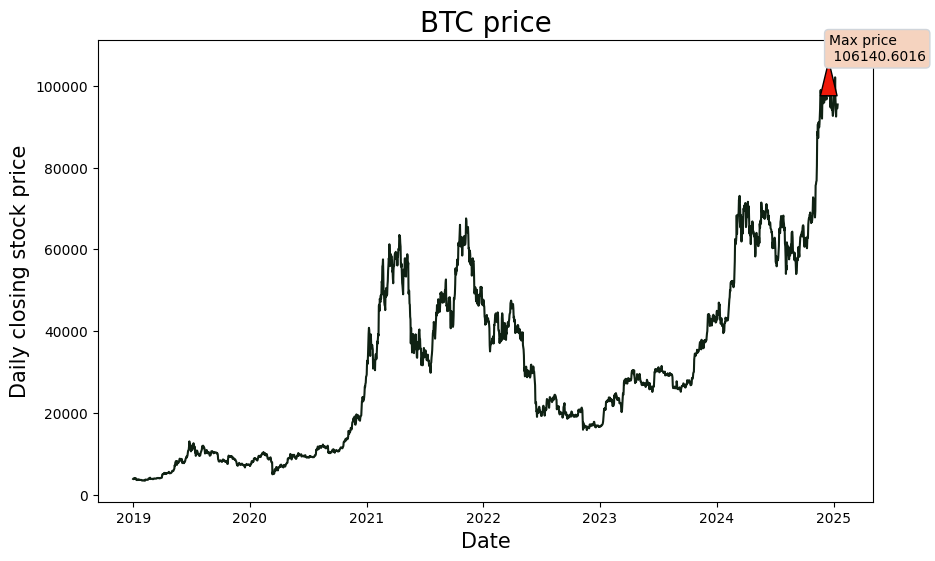

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
high = df['Close'].max()
datetime = df[df['Close'] == df['Close'].max()].index.values

ax.plot(df.index, df['Close'], color='#0f2113')
ax.set_title("BTC price", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Daily closing stock price", fontsize=15)
ax.annotate(f"Max price\n {round(high, 4)}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
plt.show()

### Вывод
- Тренд с 2023
- Шум в данных
- Не стационарный временной ряд

In [167]:
## Stationary test, Augmented Dicky-Fuller, p-value <= 0.05 stationary series
def adfuller_test(df):
    adfuller_result = adfuller(df['Close'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                            'Lags Used','Number of Observations Used'])
    return adfuller_output

# find degree of differencing 
def degree_of_differencing(df, col_name, symbol):
    company_ndiffs = ndiffs(df[col_name], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {symbol}')
    
    return company_ndiffs

def adfuller_test2(df):
    adfuller_result = adfuller(df, autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                            'Lags Used','Number of Observations Used'])
    return adfuller_output

# find degree of differencing 
def degree_of_differencing(df, symbol):
    company_ndiffs = ndiffs(df, test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {symbol}')
    
    return company_ndiffs

In [ ]:
adfuller_test(df)
# p-value greater then 0.5

Test statistic                   -0.382163
p-value                           0.913035
Lags Used                        26.000000
Number of Observations Used    2179.000000
dtype: float64

In [ ]:
ddf = degree_of_differencing(df, 'Close', 'BTC-USD')
ddf

In [ ]:
## Check data
# df['Close'].plot(figsize=(14,6))
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.grid()
# plt.show()

### Removing trend

2205


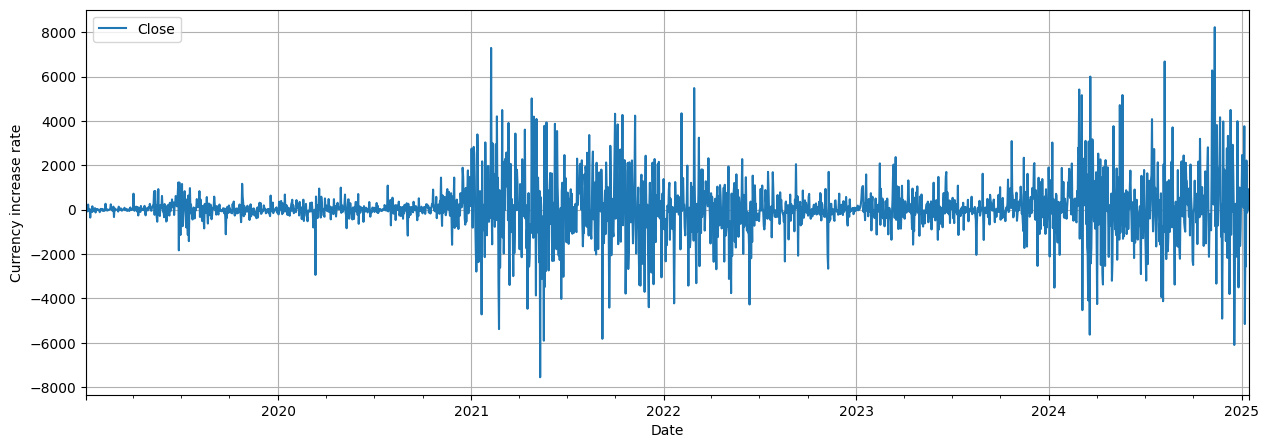

In [137]:
## Differencing
close_df = df[['Close']].copy()
close_df = close_df.diff()
close_df = close_df.dropna()
print(len(close_df))

## Plot the data to see the outcome
close_df.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Currency increase rate')
plt.grid()
plt.show()

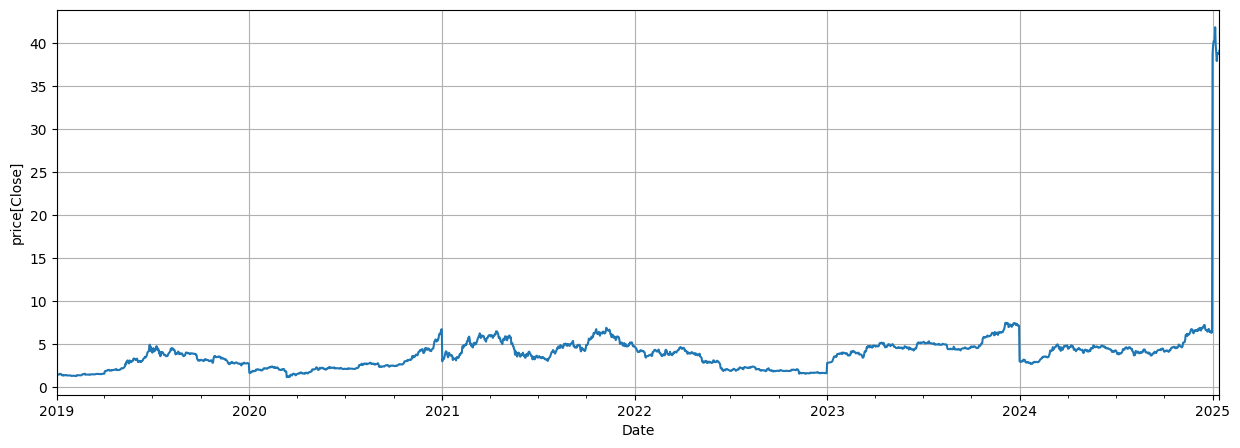

In [152]:
# Calculate each year's variance (equivalent to standard deviation)
close_df = df['Close']

annual_average = close_df.groupby(close_df.index.year).std()
mapped_annual_average = close_df.index.map(lambda x: annual_average.loc[x.year])
# month_average = close_df.groupby(close_df.index.month).std()
# mapped_month_average = close_df.index.map(lambda x: month_average.loc[x.month])

# type(close_df['Close'])
# close_df.reset_index(inplace=True)
# close_df = pd.Series(close_df['Close'])

# # Standardize each year's variance
close_df = close_df / mapped_annual_average
# close_df = close_df / mapped_month_average

# # Plot outcome
close_df.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('price[Close]')
plt.grid()
plt.show()

### Remove seasonality

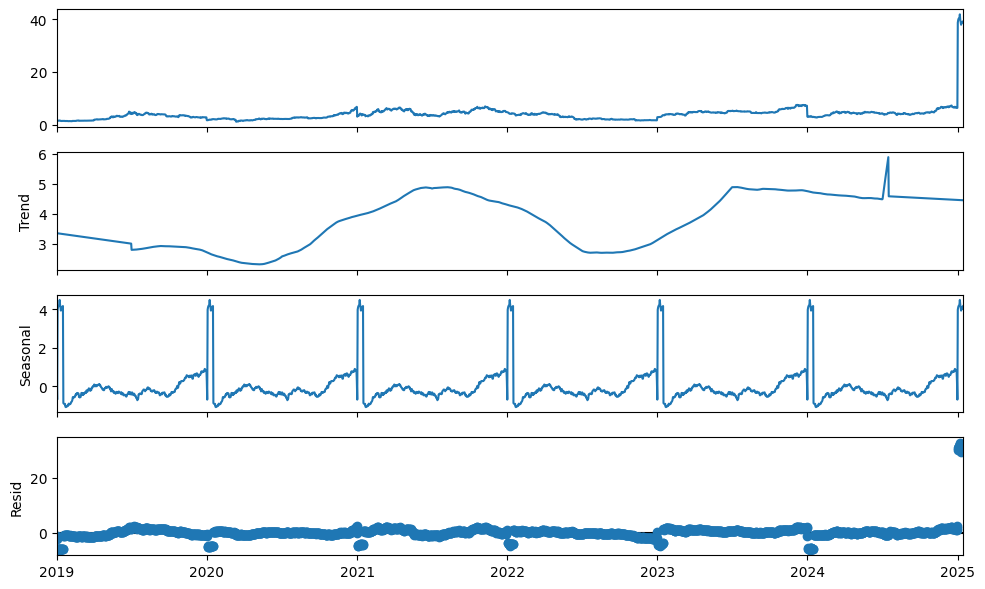

In [156]:
# result_decom = seasonal_decompose(df['Close'], model="multiplicative", period=365, extrapolate_trend='freq')
result_decom = seasonal_decompose(close_df, period=365, extrapolate_trend='freq')
# plot
fig = result_decom.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

### STL(Seasonal-Trend decomposition using LOESS)

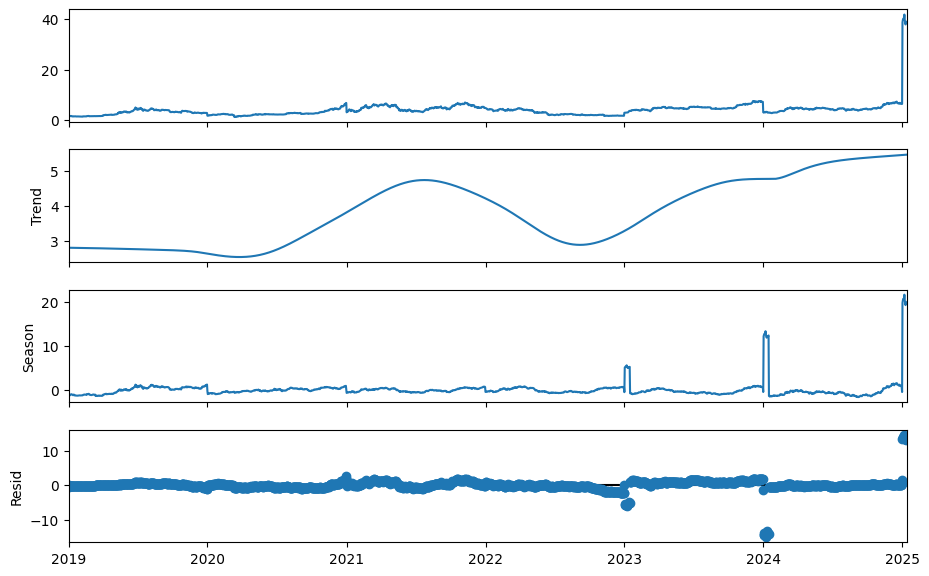

In [157]:
# stl = STL(df['Close'], period=365, trend_deg=0)
stl = STL(close_df, period=365, trend_deg=0)
res = stl.fit()
fig = res.plot()
fig.set_size_inches((10, 6))

In [168]:
# Perform ADF test
result = adfuller(close_df)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(close_df)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))


ADF test:	p-value: 0.988
KPSS test:	p-value: 0.010


Test statistic                    0.624497
p-value                           0.988204
Lags Used                         6.000000
Number of Observations Used    2199.000000
dtype: float64

In [171]:
# Apply one more differencing to the data
close_df = close_df.diff()[1:]

# Perform ADF test
result = adfuller(close_df)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(close_df)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

adfuller_test2(close_df)


# close_df.plot(figsize=(15,5))
# plt.xlabel('Date')
# plt.ylabel('price[Close]')
# plt.grid()
# plt.show()

ADF test:	p-value: 0.000
KPSS test:	p-value: 0.100


Test statistic                  -20.426849
p-value                           0.000000
Lags Used                        26.000000
Number of Observations Used    2176.000000
dtype: float64

In [ ]:
# data = df.reset_index()
# close_df = data[['Date', 'Close']].copy();
c_df = df[['Close']].copy();
# close_df.set_index('Date', inplace=True)
# print(close_df.isna().sum())
# close_df.dropna()

# train_size = len(close_df) * 4 // 5
# y_train = close_df[:train_size]
# y_test = close_df[train_size:]

c_df


In [ ]:
# ets_aaa = sm.tsa.statespace.ExponentialSmoothing(c_df, trend=True,  seasonal=12)
# # ets_aaa = sm.tsa.statespace.ExponentialSmoothing(close_df, trend=True,  seasonal=24, freq='Y')
# ets_aaa_res = ets_aaa.fit()
# # ets_aaa_res = ets_aaa.fit(use_boxcox=True)
# print(ets_aaa_res.summary())

## Train forecasting models using Auto-ARIMA

### ARIMA: Авторегрессионная Интегрированная Модель Скользящего Среднего

ARIMA (Auto Regressive Integrated Moving Average) - это модель, которая предсказывает будущие движения ценных бумаг или финансового рынка, анализируя различия между значениями в ряду, а не сами значения.

Модель ARIMA можно понять, рассмотрев каждый из ее компонентов:

Авторегрессия (AR): Описывает модель, в которой переменная изменяется в зависимости от своих собственных отстающих (прошлых) значений.

Интегрирование (I): Представляет собой дифференцирование исходных наблюдений, чтобы сделать временной ряд стационарным (то есть значения данных заменяются разницей между текущим значением и предыдущим значением).

Скользящее среднее (MA): Включает зависимость между текущим наблюдением и остатком (ошибкой) от модели скользящего среднего, применяемой к отстающим наблюдениям.

In [204]:
# function to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df) * 0.95)
    train_df = (df['Close'])[:size]
    test_df = (df['Close'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

train_data, test_data = arima_split(c_df, 'BTC-USD')

def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

model_btc = find_best_fit_arima(train_data, 'BTC')

data splits of company BTC-USD
Train Size: 2095, Test Size: 111
-------------------------------
Arima model for BTC
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=37602.073, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=36042.879, Time=1.86 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=36793.756, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=37604.174, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=36456.083, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=35828.088, Time=16.88 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=39.13 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=6.81 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=37603.090, Time=1.43 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=35828.770, Time=17.30 sec
 ARIMA(1,0,1)(2,1,0)[3] intercept   : AIC=35829.034, Time=21.77 sec
 ARIMA(0,0,1)(2,1,0)[3] intercept   : AIC=36794.62

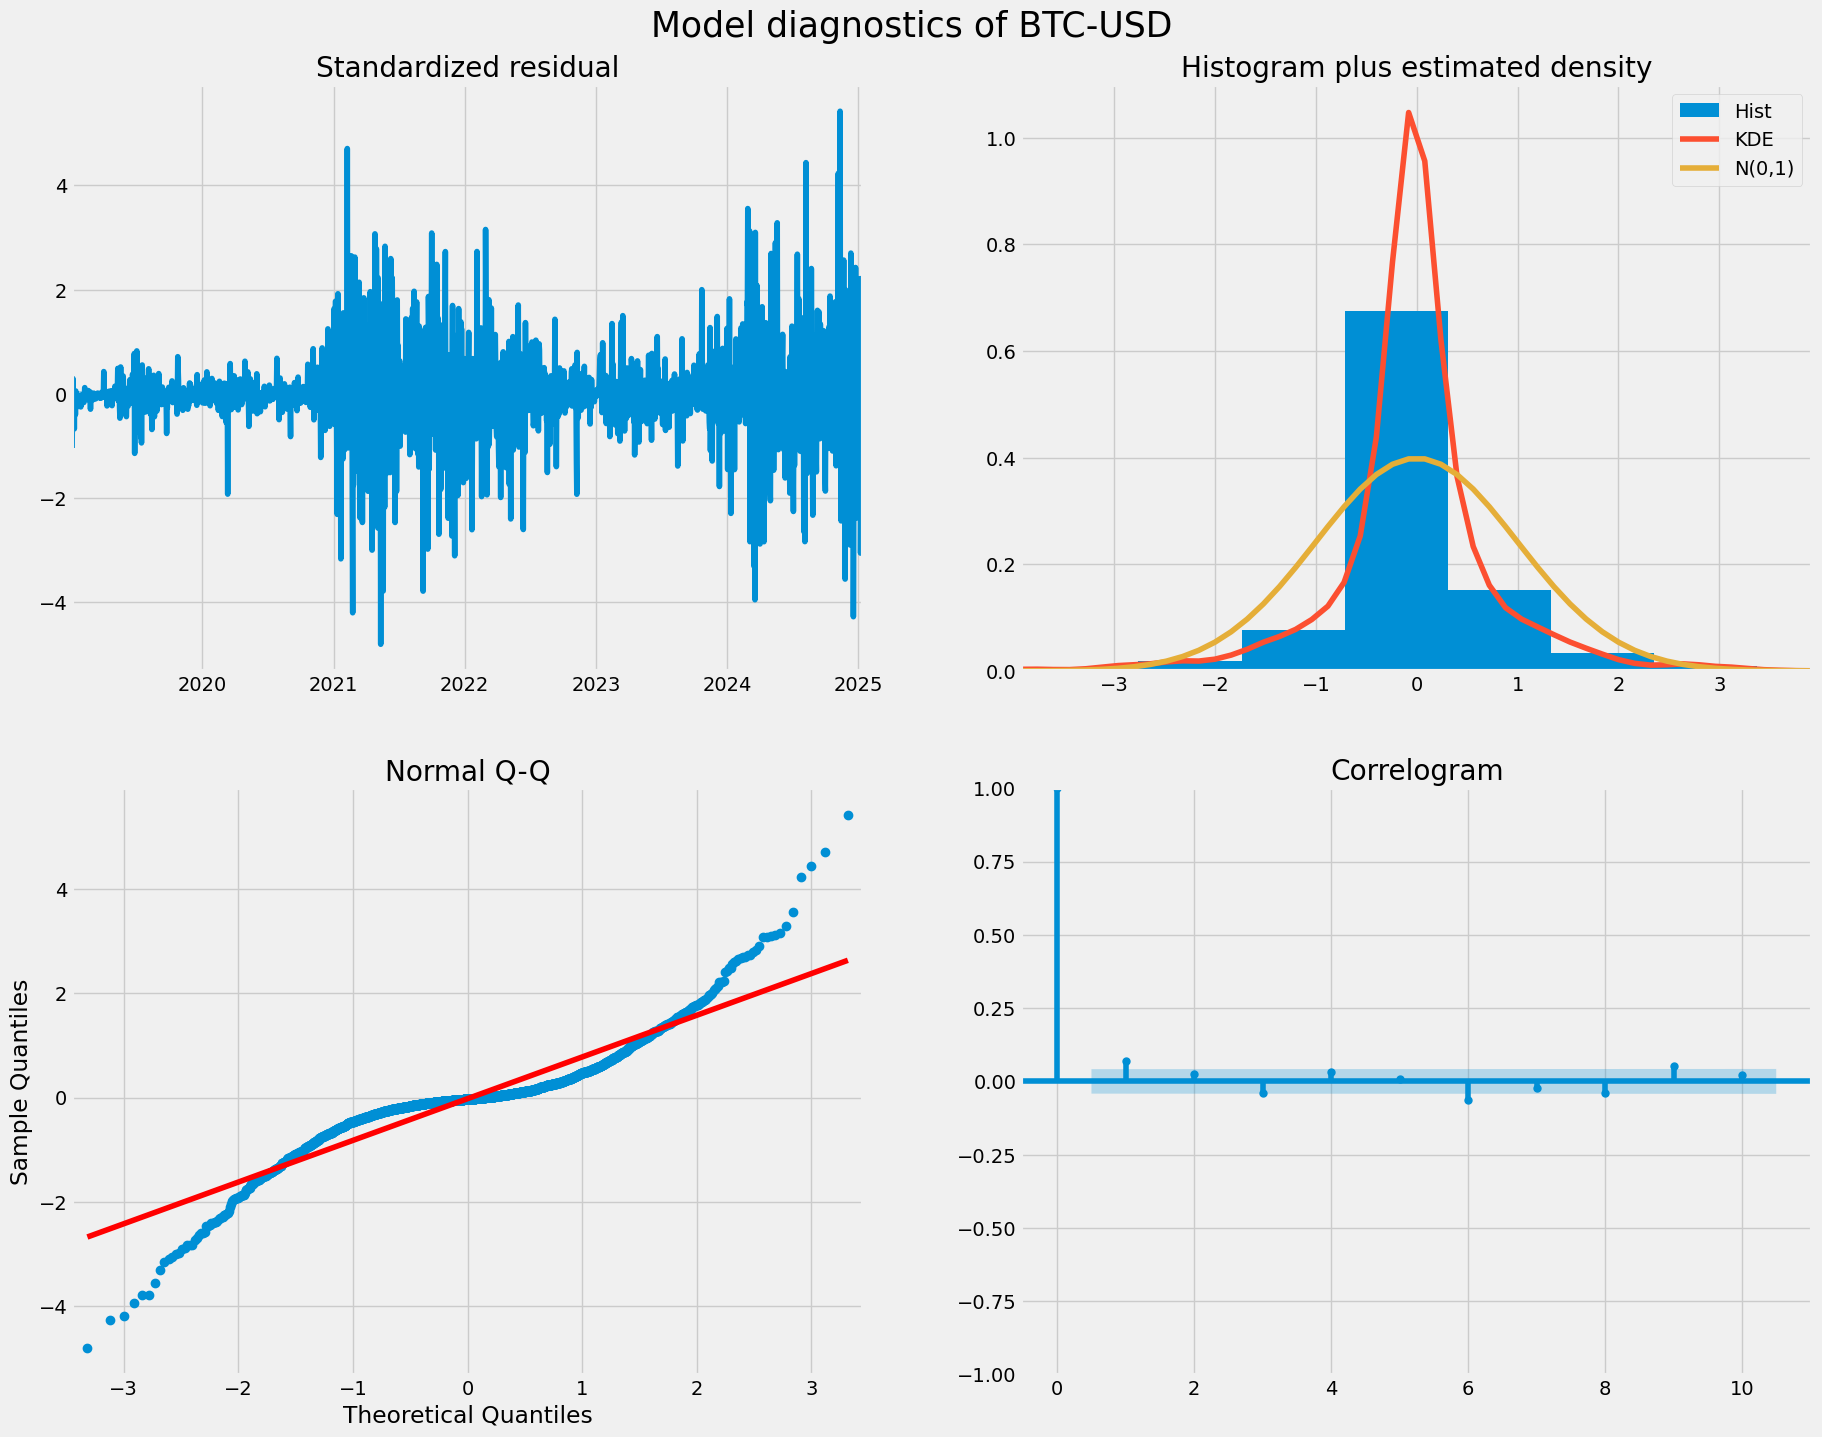

In [203]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(model_btc, 'BTC-USD')